# SETUP

In [2]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer, compute_per_channel_dice
from os import listdir
from scipy import ndimage as ndi
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet
import torch
from datetime import datetime
from astropy.io import fits
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel
from scipy import ndimage as ndi
from skimage.util.shape import view_as_windows
import skimage.measure as skmeas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap
from numpy.lib.stride_tricks import as_strided
import pickle
from sklearn.mixture import GaussianMixture
from scipy import stats
from datetime import datetime

## Load model

Properties of pre-trained model

In [2]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=2
inChannels=1
terminal_show_freq=50
model='VNET'
opt='adam'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}
k = 0
model_name = model
date_str = ""
save = '../saved_models_12052021_183655_/fold_' + str(k) + '_checkpoints/'

Load pre-trained model

In [3]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=2
        self.pretrained = pretrained
model_loc = "../VNET__last_epoch.pth"
# args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
model, optimizer = create_model(args)
model.restore_checkpoint(args.pretrained)
model.eval()
print("Loaded")

Building Model . . . . . . . .VNET
VNET Number of params: 45603934
Loaded


In [4]:
train_df = pd.read_csv("../saved_models_12052021_183655_/fold_%s_checkpoints/VNET_/train.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../saved_models_12052021_183655_/fold_%s_checkpoints/VNET_/val.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
train_df["epoch"] = train_df["epoch"].str.split("Loss", expand=True)[0]
val_df["epoch"] = val_df["epoch"].str.split("Loss", expand=True)[0]
train_df["loss"] = train_df["loss"].str.split(" ", expand=True)[0]
val_df["loss"] = val_df["loss"].str.split(" ", expand=True)[0]

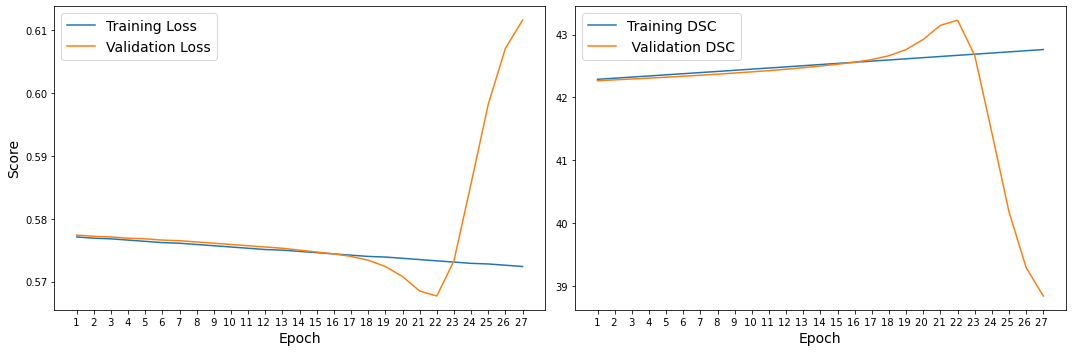

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

axes[0].plot(train_df.epoch, train_df.loss.astype(float), label="Training Loss")
axes[0].plot(val_df.epoch, val_df.loss.astype(float), label="Validation Loss")
axes[1].plot(train_df.epoch, train_df.dsc.astype(float), label="Training DSC")
axes[1].plot(val_df.epoch, val_df.dsc.astype(float), label=" Validation DSC")

axes[0].set_xlabel("Epoch", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Score", fontsize=14)
# axes[1].set_ylabel("Score")
axes[0].legend(fontsize=14)
axes[1].legend(fontsize=14)
fig.tight_layout()

## F-Score

In [5]:
def f_score(inter, all_of):
    dice = 2*inter/all_of
    return dice
def intersection(A, B):
    return np.nansum(np.logical_and(A, B).astype(int))

def all_AB(A, B):
    return np.nansum(A) + np.nansum(B)

# Evaluate Model

Load the test subcubes

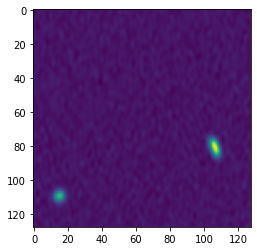

In [4]:
orig_data = fits.getdata("../data/training/Input/loud_1245mosC.fits")
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
orig_subcube = orig_data[133:197, 800:800+128, 1500:1500+128]
real_subcube = realseg_data[133:197, 800:800+128, 1500:1500+128]
data_loader_tensor = torch.FloatTensor(np.moveaxis(orig_subcube, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
plt.imshow(orig_subcube[32])

In [53]:
model.eval()
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
out_np = np.moveaxis(out_cube.squeeze()[0].numpy(), 2, 0)
smoothed_gal = ndi.gaussian_filter(out_np, sigma=0.01)
clipped = smoothed_gal > np.mean(smoothed_gal)+np.std(smoothed_gal)

In [54]:
gt = (real_subcube).flatten().tolist()
pred = (clipped).flatten().tolist()
f_score(intersection(gt, pred), all_AB(gt, pred))

0.7638397281608381

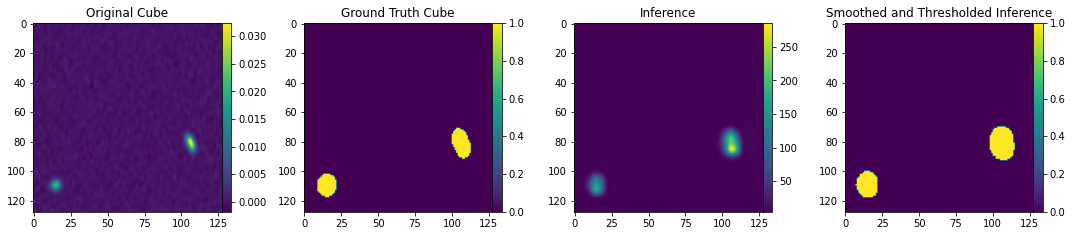

In [56]:
fig, axes = plt.subplots(1, 4, figsize = (15, 5))
im0 = axes[0].imshow(orig_subcube[32])
cax0 = make_axes_locatable(axes[0]).append_axes("right", size="5%",pad=0)
fig.colorbar(im0, cax=cax0)
axes[0].set_title("Original Cube")


im3 = axes[1].imshow(real_subcube[32])
cax3 = make_axes_locatable(axes[1]).append_axes("right", size="5%",pad=0)
fig.colorbar(im3, cax=cax3)
axes[1].set_title("Ground Truth Cube")

im1 = axes[2].imshow(out_np[32])
cax1 = make_axes_locatable(axes[2]).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
axes[2].set_title("Inference")

im2 = axes[3].imshow(clipped[32])
cax2 = make_axes_locatable(axes[3]).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
axes[3].set_title("Smoothed and Thresholded Inference")


# im4 = axes[4].imshow(out_mask.squeeze()[0][..., 34])
# cax4 = make_axes_locatable(axes[4]).append_axes("right", size="5%",pad=0)
# fig.colorbar(im4, cax=cax4)
# axes[4].set_title("Inference on GT")

# im5 = axes[5].imshow(object_labels_mask[..., 34])
# cax5 = make_axes_locatable(axes[5]).append_axes("right", size="5%",pad=0)
# fig.colorbar(im5, cax=cax5)
# axes[5].set_title("Post-Processed Inference on GT")

fig.tight_layout()

## Inference on a full cube
stitch sliding window together

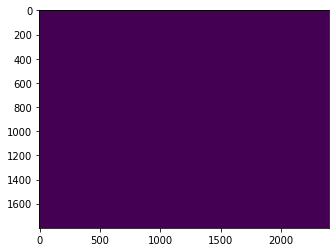

In [4]:
dims = [128, 128, 64]
overlaps = [15, 20, 20]
orig_data = fits.getdata("../data/training/Input/loud_1245mosC.fits")
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
test_file = "loud_1245mosC-slidingwindowindices.txt"
with open(test_file, "rb") as fp:
    test_list = pickle.load(fp)
for index, window in enumerate(test_list):
    test_list[index][0][0] = "." + window[0][0].replace("loudInput", "Input")
    test_list[index][0][1] = "." + window[0][1]
# z_test_list = [i for i in test_list if i[3] in [[176, 240]]]
empty_arr = np.zeros((652, 1800, 2400))*np.nan
plt.imshow(realseg_data[32])
plt.show()

In [71]:
object_labels = skmeas.label(realseg_data[176:284])
print("Number of inserted sources =", len(np.unique(object_labels)))

Number of inserted sources = 67


In [8]:
z_test_list = [i for i in test_list if i[3] in [[176, 240], [220, 284]]]
len(z_test_list)

660

 6.818181818181818 %%%

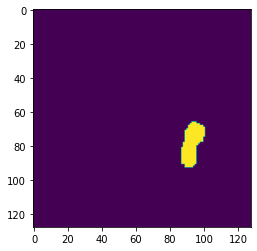

 6.96969696969697 %

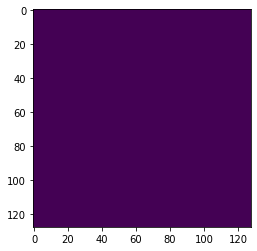

 7.121212121212121 %

KeyboardInterrupt: 

In [10]:
for index, window in enumerate(z_test_list):
    cube_files, x, y, z = window
    subcube = orig_data[z[0]:z[1], x[0]:x[1], y[0]:y[1]]
    input_tensor = torch.FloatTensor(np.moveaxis(subcube, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
    with torch.no_grad():
        out_cube = model.inference(input_tensor)
    out_np = np.moveaxis(out_cube.squeeze()[1].numpy(), 2, 0)
    binary_im = out_np > 0
    empty_arr[z[0]:z[1], x[0]:x[1], y[0]:y[1]] = np.nanmax(np.array([empty_arr[z[0]:z[1], x[0]:x[1], y[0]:y[1]], binary_im.astype(int)]), axis=0)
    if len(np.unique(binary_im.astype(int))) > 1:
        plt.imshow(empty_arr[z[0]:z[1], x[0]:x[1], y[0]:y[1]][32])
        plt.show()
    print("\r", index*100/len(z_test_list), "%", end="")


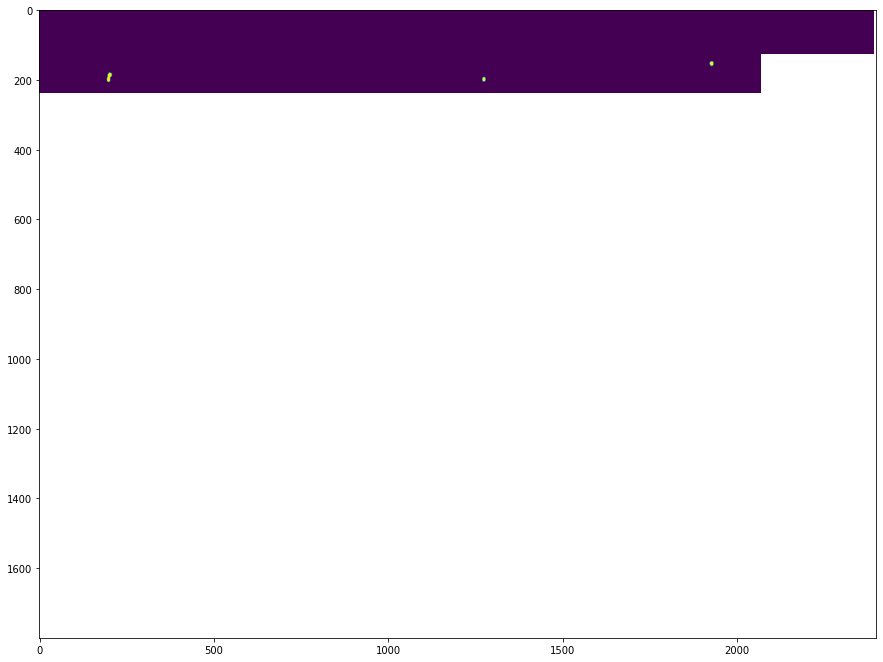

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
axes.imshow(empty_arr[176:284][32])

Threshold and add limitations

In [13]:
object_labels = skmeas.label(empty_arr[176:284])
print("Number of found sources =", len(np.unique(object_labels)))

Number of found sources = 57


## Plot Combined Scores

In [73]:
freq_dict = {"mask_1245mosB.fits": [1401252439.970,1425092772.001],
"mask_1245mosC.fits": [1381037599.970,1404877932.001],
"mask_1245mosD.fits": [1360822751.970,1384663084.001],
"mask_1245mosE.fits": [1340607911.970,1364448244.001],
"mask_1245mosF.fits": [1320393067.970,1344233400.001],
"mask_1245mosG.fits": [1300178221.970,1324018554.001],
"mask_1245mosH.fits": [1279963378.910,1303803710.941],
"mask_1353mosB.fits": [1401179199.970,1425019532.001],
"mask_1353mosC.fits": [1380964351.970,1404804684.001],
"mask_1353mosD.fits": [1360749511.970,1384589844.001],
"mask_1353mosE.fits": [1340534667.970,1364375000.001],
"mask_1353mosF.fits": [1320319823.970,1344160156.001],
"mask_1353mosG.fits": [1300104979.970,1323945312.001],
"mask_1353mosH.fits": [1279890136.720,1303730468.751]}
df = pd.DataFrame(freq_dict.values(), columns=[["freq_1", "freq_2"]])
df["file_names"] = freq_dict.keys()
df["freq_1_round"] = np.round(df['freq_1']*1e-6).astype(int).astype(str)
df["freq_2_round"] = np.round(df['freq_2']*1e-6).astype(int).astype(str)
df['freq_labels'] = df[['freq_1_round', 'freq_2_round']].agg('-'.join, axis=1)

In [89]:
with open("../results/loud_SOFIA_eval.txt", "rb") as fp:
    sofia_eval = pickle.load(fp)
sofia_dict = {}
for i in [0, 2, 4, 6, 8, 10, 12]:
    sofia_dict.update({sofia_eval[i]: sofia_eval[i+1]})
sofia_df = pd.DataFrame.from_dict(sofia_dict, orient='index', columns=[["tp", "fp", "fn", "f_score", "um", "om", "area_score", "s", "k", "bg_mean", "combined_one", "combined_two"]])
sofia_df["freq_1"] = [freq_dict["mask_" + i + '.fits'][0]  for i in sofia_df.index]
full_sofia_df = pd.merge(df[['freq_1', 'freq_labels']], sofia_df)
# sofia_comb_a = [sofia_dict[key][-2] for key in sofia_dict.keys()]
# sofia_comb_b = [sofia_dict[key][-1] for key in sofia_dict.keys()]

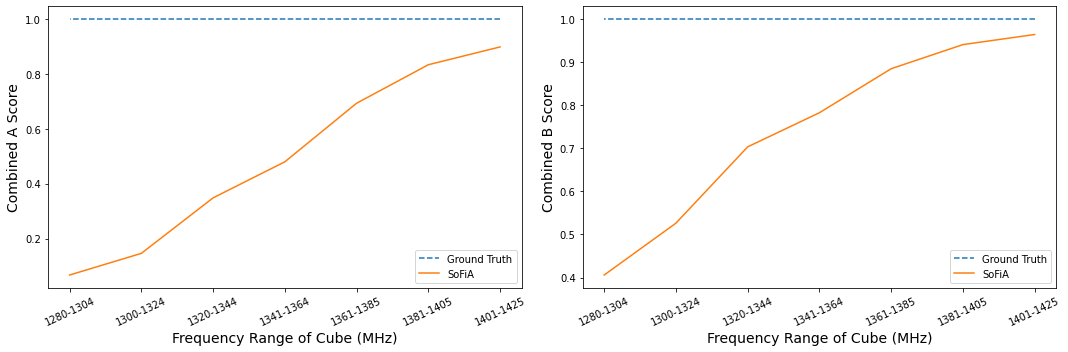

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_ylabel("Combined A Score", fontsize=14)
ax1.set_xticks(ticks=[i[0] for i in full_sofia_df.freq_1.values])
ax1.set_xticklabels([i[0] for i in full_sofia_df.freq_labels.values], rotation=25)
ax1.plot(full_sofia_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax1.plot(full_sofia_df.freq_1, full_sofia_df.combined_one, label="SoFiA")
# ax1.plot(np.unique(df["freq_1"]), [mto_eval_stats[-2]]*7, label="MTObjects")
# ax1.plot(np.unique(df["freq_1"]), [eval_stats[-2]]*7, label="V-Net")
ax1.tick_params(axis='y')
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.legend()


ax2.set_ylabel("Combined B Score", fontsize=14)
ax2.set_xticks(ticks=[i[0] for i in full_sofia_df.freq_1.values])
ax2.set_xticklabels([i[0] for i in full_sofia_df.freq_labels.values], rotation=25)
ax2.plot(full_sofia_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax2.plot(full_sofia_df.freq_1, full_sofia_df.combined_two, label="SoFiA")
# ax2.plot(np.unique(df["freq_1"]), [mto_eval_stats[-1]]*7, label="MTObjects")
# ax2.plot(np.unique(df["freq_1"]), [eval_stats[-1]]*7, label="V-Net")
ax2.tick_params(axis='y')
ax2.legend()
ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)

fig.tight_layout()